<a href="https://colab.research.google.com/github/ketkiambekar/masters-research-project/blob/main/LSTM_V1_BK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd drive/MyDrive/KetkiAmbekar/Raw\ Data\ Files
%pwd
%ls

[Errno 2] No such file or directory: 'drive/MyDrive/KetkiAmbekar/Raw Data Files'
/content/drive/.shortcut-targets-by-id/1zDGtpS_EJdRSKz3jZptcq5k6f4jqXBwI/KetkiAmbekar/Raw Data Files
 covid_BK.xlsx                   NYC_housing_prices_dropped_na.csv
 covid_BX.xlsx                   NYC_Housing_prices_dropped_values.csv
 covid_MN.xlsx                   NYC_HP_LSTM.csv
 covid_QN.xlsx                  'nyc_pluto_20v7_csv(1).zip'
 covid_real_estate.csv           nyc_pluto_20v7_csv.zip
 covid_SI.xlsx                   nyc_real_estate_PLUTO_+_Final.csv
 nyc_dataset_final.xlsx          pluto_20v7.csv
 NYC_housing_prices_dropped_na   Temperatures/


In [29]:
#Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# fix random seed for reproducibility
np.random.seed(7)

In [56]:
# load the dataset
#df = pd.read_csv('NYC_HP_LSTM.csv', engine='python', index_col='sales_date', parse_dates=True )
df = pd.read_csv('NYC_HP_LSTM.csv', engine='python', parse_dates=True )
df


,Unnamed: 0,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price
0,0,1.0,0.0,0.0,0.0,0.0,66638.0,1608,2020-08-31,5585336
1,1,1.0,0.0,0.0,0.0,0.0,8300.0,1608,2020-08-31,1643000
2,2,1.0,0.0,0.0,0.0,0.0,7488.0,1608,2020-08-31,1200000
3,3,1.0,0.0,0.0,0.0,0.0,6429.0,1608,2020-08-31,735000
4,4,1.0,0.0,0.0,0.0,0.0,7000.0,1608,2020-08-31,775000
...,...,...,...,...,...,...,...,...,...,...
76837,76837,0.0,0.0,0.0,0.0,1.0,5264.0,0,2018-01-02,680000
76838,76838,0.0,0.0,0.0,0.0,1.0,10268.0,0,2018-01-02,400000
76839,76839,0.0,0.0,0.0,0.0,1.0,4901.0,0,2018-01-02,565000
76840,76840,0.0,0.0,0.0,0.0,1.0,6525.0,0,2018-01-02,499500


In [57]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price
0,1.0,0.0,0.0,0.0,0.0,66638.0,1608,2020-08-31,5585336
1,1.0,0.0,0.0,0.0,0.0,8300.0,1608,2020-08-31,1643000
2,1.0,0.0,0.0,0.0,0.0,7488.0,1608,2020-08-31,1200000
3,1.0,0.0,0.0,0.0,0.0,6429.0,1608,2020-08-31,735000
4,1.0,0.0,0.0,0.0,0.0,7000.0,1608,2020-08-31,775000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76842 entries, 0 to 76841
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   borough_BK   76842 non-null  float64
 1   borough_BX   76842 non-null  float64
 2   borough_MN   76842 non-null  float64
 3   borough_QN   76842 non-null  float64
 4   borough_SI   76842 non-null  float64
 5   tot_area     76842 non-null  float64
 6   covid_cases  76842 non-null  int64  
 7   sales_date   76842 non-null  object 
 8   sales_price  76842 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 5.3+ MB


In [59]:
df['covid_cases']=df.covid_cases.astype('float64')
df['sales_price']=df.sales_price.astype('float64')
df['per_sqft_rate']=df['sales_price']/df['tot_area']

In [60]:
df.head()

,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price,per_sqft_rate
0,1.0,0.0,0.0,0.0,0.0,66638.0,1608.0,2020-08-31,5585336.0,83.816081
1,1.0,0.0,0.0,0.0,0.0,8300.0,1608.0,2020-08-31,1643000.0,197.951807
2,1.0,0.0,0.0,0.0,0.0,7488.0,1608.0,2020-08-31,1200000.0,160.256410
3,1.0,0.0,0.0,0.0,0.0,6429.0,1608.0,2020-08-31,735000.0,114.325712
4,1.0,0.0,0.0,0.0,0.0,7000.0,1608.0,2020-08-31,775000.0,110.714286


In [62]:
#We need to separate boroughs Let's first create a model for Brooklyn only

df_BK = df[df['borough_BK']==1.0]
df_BK = df_BK[['tot_area', 'covid_cases', 'sales_date','sales_price','per_sqft_rate' ]]
df_BK

,tot_area,covid_cases,sales_date,sales_price,per_sqft_rate
0,66638.0,1608.0,2020-08-31,5585336.0,83.816081
1,8300.0,1608.0,2020-08-31,1643000.0,197.951807
2,7488.0,1608.0,2020-08-31,1200000.0,160.256410
3,6429.0,1608.0,2020-08-31,735000.0,114.325712
4,7000.0,1608.0,2020-08-31,775000.0,110.714286
...,...,...,...,...,...
20096,7024.0,0.0,2018-01-02,1270000.0,180.808656
20097,358240.0,0.0,2018-01-02,213000.0,0.594573
20098,5346.0,0.0,2018-01-02,200000.0,37.411149
20099,3826.0,0.0,2018-01-02,505000.0,131.991636


In [63]:
sales_date = df['sales_date']

In [64]:
#We ensure, one datapoint per date. 
#We therefore, groupby sales_date column and aggregate over per_sqft_rate column on it's mean andchoose max number of covid_cases.
df_BK=df_BK.groupby(["sales_date"]).agg({'per_sqft_rate':'mean', 'covid_cases':'max'})
df_BK

,per_sqft_rate,covid_cases
sales_date,,
2018-01-02,192.782887,0.0
2018-01-03,101.595929,0.0
2018-01-04,115.135626,0.0
2018-01-05,138.580350,0.0
2018-01-07,53.516820,0.0
...,...,...
2020-08-25,152.301999,1608.0
2020-08-26,211.410674,1608.0
2020-08-27,160.964074,1608.0


In [65]:
df_BK.describe()

,per_sqft_rate,covid_cases
count,733.000000,733.000000
mean,155.399371,1635.724420
std,71.809305,5178.086032
min,0.399773,0.000000
25%,126.699209,0.000000
50%,152.025116,0.000000
75%,172.814200,0.000000
max,1065.952914,26878.000000


In [66]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
print(df_BK.shape)
scaler = StandardScaler()
scaler = scaler.fit(df_BK)
df_scaled = scaler.transform(df_BK)
df_scaled

(733, 2)


array([[ 0.52094979, -0.31610934],
       [-0.74976607, -0.31610934],
       [-0.56108659, -0.31610934],
       ...,
       [ 0.07754571, -0.00535784],
       [-0.49337306, -0.00535784],
       [-0.48541044, -0.00535784]])

In [67]:
df_scaled.shape

(733, 2)

In [68]:
import numpy as np
df_BK['scaled_per_sqft_rate']= df_scaled[:,0]
df_BK['scaled_covid_cases']= df_scaled[:,1]
df_BK.head()

,per_sqft_rate,covid_cases,scaled_per_sqft_rate,scaled_covid_cases
sales_date,,,,
2018-01-02,192.782887,0.0,0.520950,-0.316109
2018-01-03,101.595929,0.0,-0.749766,-0.316109
2018-01-04,115.135626,0.0,-0.561087,-0.316109
2018-01-05,138.580350,0.0,-0.234378,-0.316109
2018-01-07,53.516820,0.0,-1.419762,-0.316109


In [69]:
df_BK.tail(10)

,per_sqft_rate,covid_cases,scaled_per_sqft_rate,scaled_covid_cases
sales_date,,,,
2020-08-18,217.331311,1608.0,0.863039,-0.005358
2020-08-19,165.559770,1608.0,0.141588,-0.005358
2020-08-20,182.369924,1608.0,0.375842,-0.005358
2020-08-21,160.687984,1608.0,0.073698,-0.005358
2020-08-24,224.797650,1608.0,0.967085,-0.005358
2020-08-25,152.301999,1608.0,-0.043163,-0.005358
2020-08-26,211.410674,1608.0,0.780533,-0.005358
2020-08-27,160.964074,1608.0,0.077546,-0.005358
2020-08-28,119.994769,1608.0,-0.493373,-0.005358


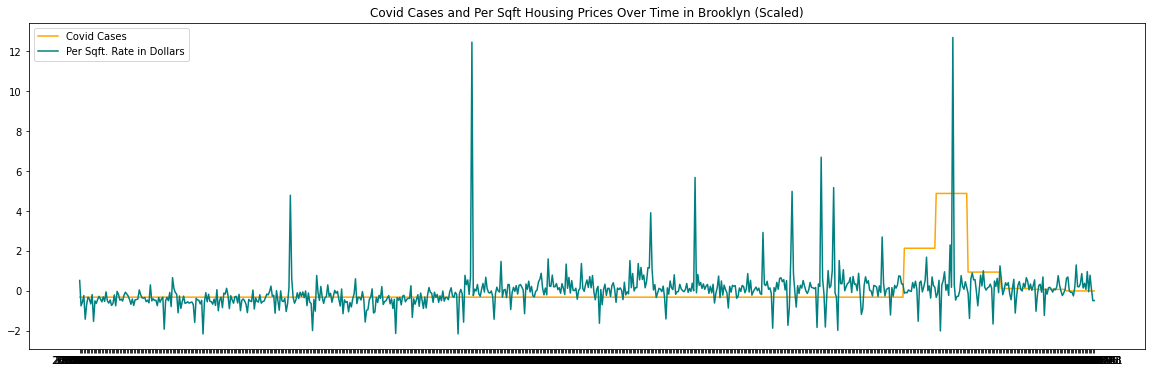

In [70]:
#Plotting Normalized Prices and Covid Cases
plt.figure(figsize=(20,6))
plt.title("Covid Cases and Per Sqft Housing Prices Over Time in Brooklyn (Scaled)")
plt.plot(df_BK['scaled_covid_cases'], linestyle='solid', color='orange', label="Covid Cases")
plt.plot(df_BK['scaled_per_sqft_rate'], linestyle='solid', color='teal', label="Per Sqft. Rate in Dollars")
plt.legend(loc="upper left")
plt.grid(False)
#sns.lineplot(data=trends.drop(['sales_price', 'covid_cases'], axis=1));

In [71]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df_BK.index)
train_dates

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27',
               '2020-08-28', '2020-08-31'],
              dtype='datetime64[ns]', name='sales_date', length=733, freq=None)

In [72]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 21     # Number of past days we want to use to predict the future


#Creating sequential window trainX for training. 
#Sample trainX window : [0.1 0.2 0.3 0.5 0.4 0.1 ]
for i in range(n_past, len(df_scaled) - n_future +1):
    trainX.append(df_scaled[i - n_past:i, 0:df_scaled.shape[1]])

    #trainY.append(df_scaled[i + n_future - 1:i + n_future, 0])
    trainY.append(df_scaled[i + n_future - 1:i + n_future, :])  #We want to predict both covid cases and per sq. ft rate, so trin y will contain both.  




In [73]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [74]:
#trainX=trainX[:800]
#trainY=trainY[:800]
trainX.shape

(712, 21, 2)

In [75]:
trainY.shape

(712, 1, 2)

In [76]:
df_scaled.shape

(733, 2)

In [77]:
print(trainX[0])

[[ 0.52094979 -0.31610934]
 [-0.74976607 -0.31610934]
 [-0.56108659 -0.31610934]
 [-0.23437778 -0.31610934]
 [-1.41976196 -0.31610934]
 [-0.69510911 -0.31610934]
 [-0.31687671 -0.31610934]
 [-0.40745861 -0.31610934]
 [-0.65507247 -0.31610934]
 [-0.18718046 -0.31610934]
 [-1.52650676 -0.31610934]
 [-0.50443672 -0.31610934]
 [-0.62305913 -0.31610934]
 [-0.42266955 -0.31610934]
 [-0.27326005 -0.31610934]
 [-0.40640678 -0.31610934]
 [-0.55007078 -0.31610934]
 [-0.30186705 -0.31610934]
 [-0.52813387 -0.31610934]
 [-0.05107189 -0.31610934]
 [-0.4990237  -0.31610934]]


In [78]:
print(trainX.shape, trainY.shape[1])

(712, 21, 2) 1


In [79]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (712, 21, 2).
trainY shape == (712, 1, 2).


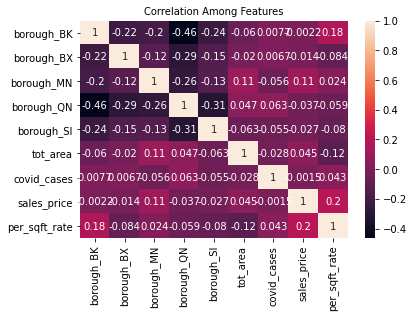

<Figure size 1080x1080 with 0 Axes>

In [80]:
# Correlations among columns
import seaborn as sns
sns.heatmap(df.corr(),annot=True);
plt.title('Correlation Among Features', size=10);
plt.figure(figsize=(15,15));
plt.show();

In [81]:
# define LSTM model
model=None
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 32)            4480      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


Train...
Epoch 1/50
43/43 [==============================] - 1s 14ms/step - loss: 0.4219 - val_loss: 1.9226
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4214 - val_loss: 1.9337
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4210 - val_loss: 1.9309
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4214 - val_loss: 1.9292
Epoch 5/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4210 - val_loss: 1.9331
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4214 - val_loss: 1.9313
Epoch 7/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4219 - val_loss: 1.9319
Epoch 8/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4217 - val_loss: 1.9314
Epoch 9/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4216 - val_loss: 1.9326
Epoch 10/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4212 - val_loss: 1.9384


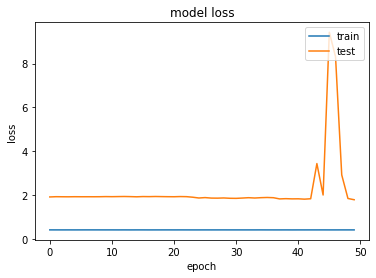

In [92]:
print('Train...')

#fit

history = model.fit(trainX, trainY, epochs=50, batch_size=10, validation_split=0.35, verbose=1)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [83]:
print(len(history.history['loss']))

10


In [84]:
print(len(train_dates))

733


In [88]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90 #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
#print(type(forecast_period_dates[0]))

forecast = model.predict(trainX[-n_future:]) #forecast 
#print(forecast)
#Perform inverse transformation to rescale back to original range
#Since we used 2 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 2 times and discard them after inverse transform
#forecast_copies=None
forecast_copies = np.repeat(forecast,2, axis=-1)
print(forecast.shape)

#Inverse Transform the forecast using previous scaler
y_pred_future = scaler.inverse_transform(forecast_copies)[:,:]

# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())


print(np.array(forecast_dates).shape)
print(np.array(y_pred_future[:,0]).shape)
    
df_forecast = pd.DataFrame({'sales_date':np.array(forecast_dates), 'per_sqft_rate':y_pred_future[:,0]})
df_forecast['sales_date']=pd.to_datetime(df_forecast['sales_date'])
original = pd.DataFrame()
original['per_sqft_rate'] = df_BK['per_sqft_rate']
original['sales_date']=train_dates
original['sales_date']=pd.to_datetime(original['sales_date'])
original=original[0:-1]
original = original[original['sales_date'] >= '2020-8-1']
original.head()



(90, 1)
(90,)
(90,)


,per_sqft_rate,sales_date
sales_date,,
2020-08-03,200.676098,2020-08-03
2020-08-04,205.187197,2020-08-04
2020-08-05,155.588903,2020-08-05
2020-08-06,150.377652,2020-08-06
2020-08-07,150.152849,2020-08-07


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


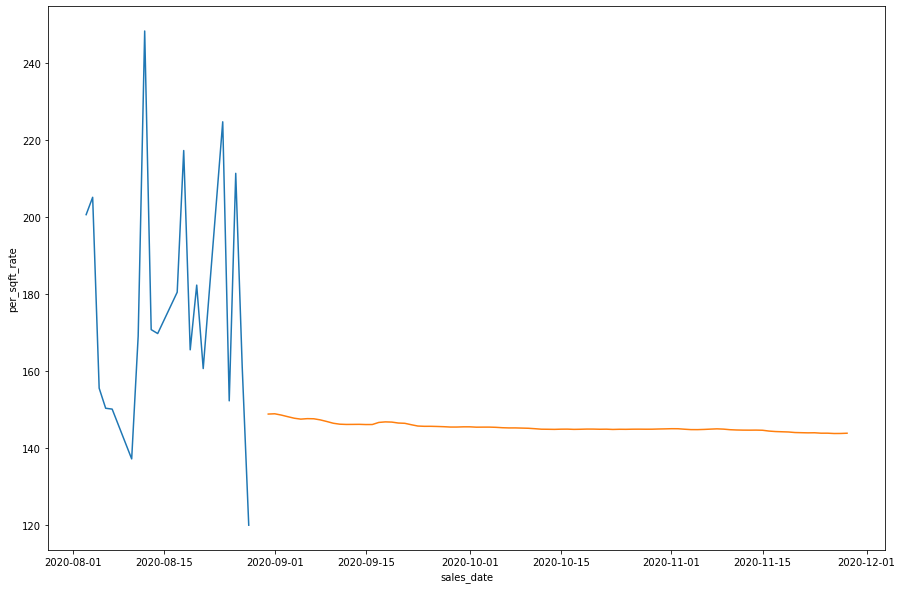

In [89]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(original['sales_date'], original['per_sqft_rate']);
sns.lineplot(df_forecast['sales_date'], df_forecast['per_sqft_rate']);
